## PyTorch

In [1]:
import torchvision.models as models

model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s]


In [2]:
from torchvision import datasets, transforms, models

data_dir = "/content/drive/MyDrive/ColabNotebooks/Modern Computer Vision My Code/imagesDL"

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])

In [3]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
!wget https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json

--2024-05-27 20:38:36--  https://raw.githubusercontent.com/rajeevratan84/ModernComputerVision/main/imageNetclasses.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33567 (33K) [text/plain]
Saving to: ‘imageNetclasses.json’

imageNetclasses.jso 100%[===================>]  32.78K  --.-KB/s    in 0.001s  

2024-05-27 20:38:37 (25.7 MB/s) - ‘imageNetclasses.json’ saved [33567/33567]



In [13]:
import torch
import json
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("imageNetclasses.json") as f:
  class_names = json.load(f)

In [16]:
if torch.cuda.is_available():
    model.cuda()

In [17]:
image = Image.open(data_dir + "/class1/00006.jpg")

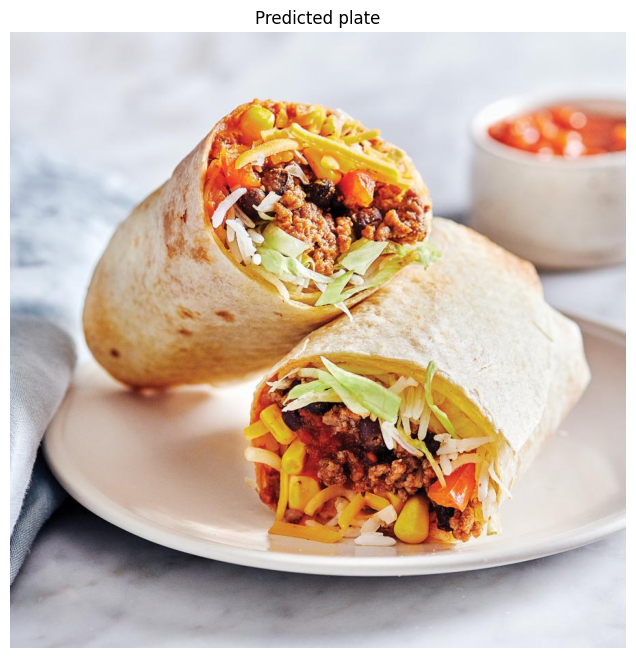

In [18]:
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model(input)
index = output.data.cpu().numpy().argmax()
name = class_names[str(index)]

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Predicted {name}")
plt.imshow(image)
plt.show()

In [19]:
import torch.nn.functional as nnf

prob = nnf.softmax(output, dim=1)
top_p, top_class = prob.topk(5, dim=1)
print(top_p, top_class)

tensor([[0.2199, 0.0787, 0.0778, 0.0638, 0.0626]], device='cuda:0',
       grad_fn=<TopkBackward0>) tensor([[923, 969, 551, 931, 928]], device='cuda:0')


In [20]:
top_class_np = top_class.cpu().data.numpy()[0]
top_class_np

array([923, 969, 551, 931, 928])

In [21]:
def getClassNames(top_classes):
  top_classes = top_classes.cpu().data.numpy()[0]
  all_classes = []
  for top_class in top_classes:
    all_classes.append(class_names[str(top_class)])
  return all_classes

In [22]:
getClassNames(top_class)

['plate', 'eggnog', 'face powder', 'bagel, beigel', 'ice cream, icecream']

In [23]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 16))

def getRankN(model, directory, ground_truth, N, show_images=True):
  onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
  all_top_classes = []
  for (i, image_filename) in enumerate(onlyfiles):
    image = Image.open(directory+image_filename)

    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)

    prob = nnf.softmax(output, dim=1)
    top_p, top_class = prob.topk(N, dim=1)
    top_class_names = getClassNames(top_class)
    all_top_classes.append(top_class_names)

    if show_images:
      sub = fig.add_subplot(len(onlyfiles), 1, i+1)
      x = " ,".join(top_class_names)
      print(f"Top {N} Predicted Classes {x}")
      plt.axis("off")
      plt.imshow(image)
      plt.show()
  return getScore(all_top_classes, ground_truth, N)

def getScore(all_top_classes, ground_truth, N):
  in_labels = 0
  for (i, labels) in enumerate(all_top_classes):
    if ground_truth[i] in labels:
      in_labels += 1
  return f"Rank-{N} Accuracy = {in_labels/len(all_top_classes)*100:.2f}"

<Figure size 1600x1600 with 0 Axes>

In [24]:
ground_truth = ['limousine, limo',
                'basketball',
                'collie',
                'doormat, welcome mat',
                'Christmas stocking',
                'burrito',
                "spider web, spider's web",
                ]

Top 5 Predicted Classes limousine, limo ,beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon ,convertible ,pickup, pickup truck ,ambulance


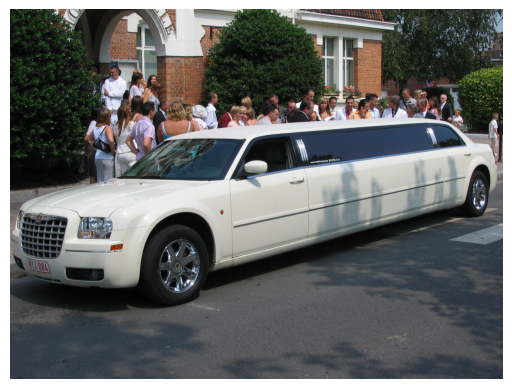

Top 5 Predicted Classes basketball ,volleyball ,ping-pong ball ,rugby ball ,soccer ball


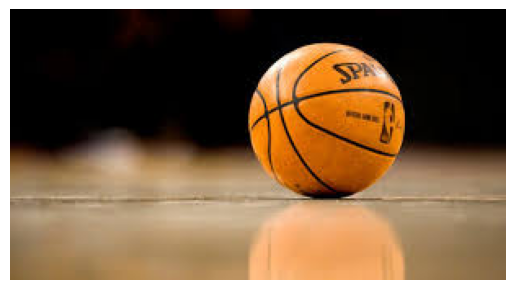

Top 5 Predicted Classes Afghan hound, Afghan ,collie ,borzoi, Russian wolfhound ,briard ,Saluki, gazelle hound


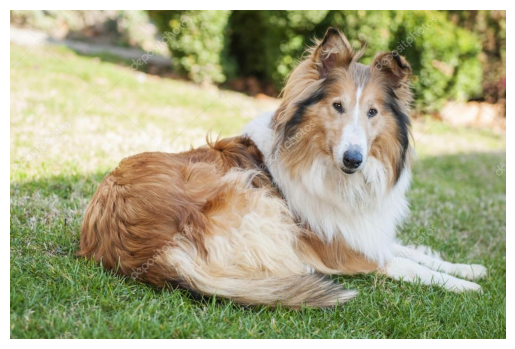

Top 5 Predicted Classes doormat, welcome mat ,chest ,paper towel ,toilet tissue, toilet paper, bathroom tissue ,carton


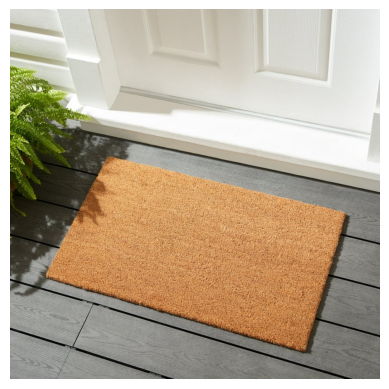

Top 5 Predicted Classes pinwheel ,Christmas stocking ,handkerchief, hankie, hanky, hankey ,umbrella ,apron


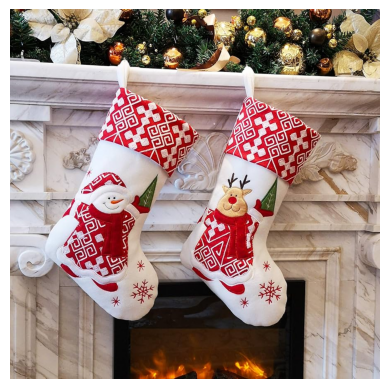

Top 5 Predicted Classes plate ,eggnog ,face powder ,bagel, beigel ,ice cream, icecream


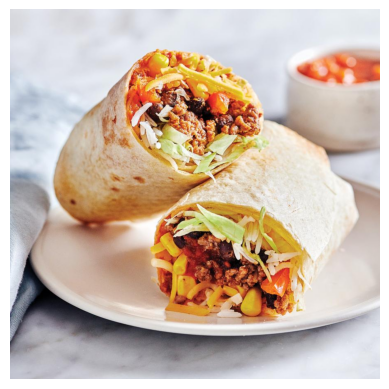

Top 5 Predicted Classes spider web, spider's web ,barn spider, Araneus cavaticus ,garden spider, Aranea diademata ,black and gold garden spider, Argiope aurantia ,wolf spider, hunting spider


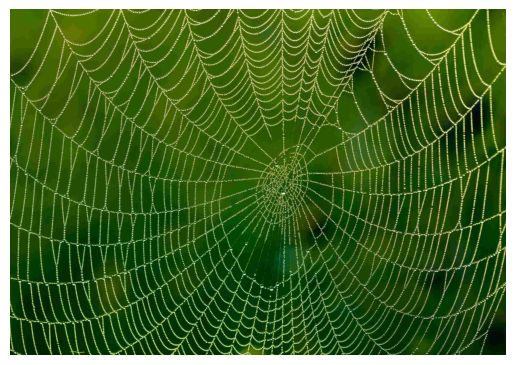

'Rank-5 Accuracy = 85.71'

In [25]:
getRankN(model, data_dir + "/class1/", ground_truth, N=5)

Top 1 Predicted Classes limousine, limo


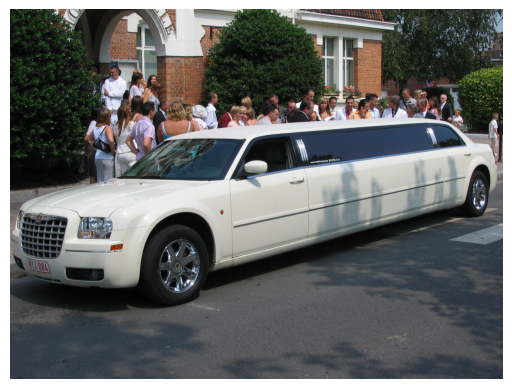

Top 1 Predicted Classes basketball


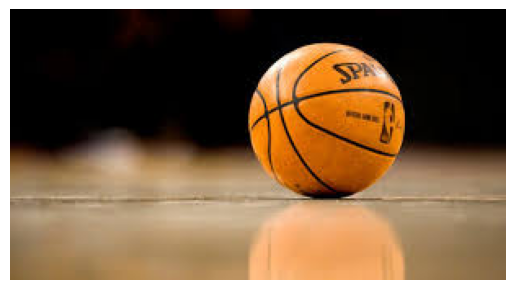

Top 1 Predicted Classes Afghan hound, Afghan


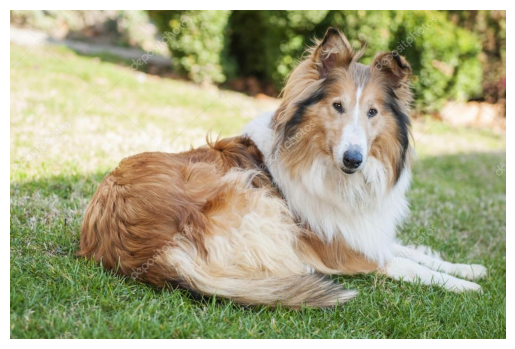

Top 1 Predicted Classes doormat, welcome mat


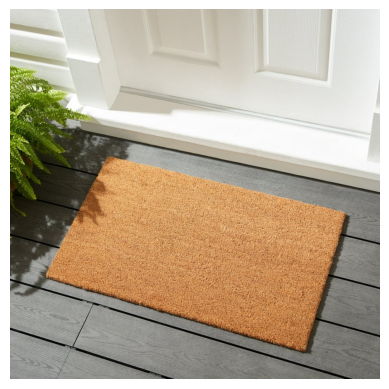

Top 1 Predicted Classes pinwheel


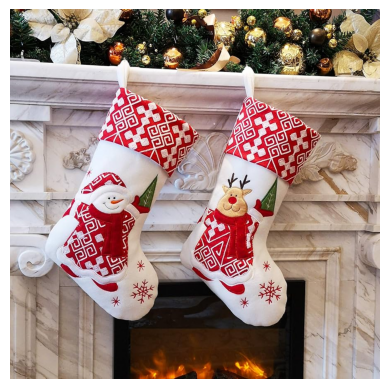

Top 1 Predicted Classes plate


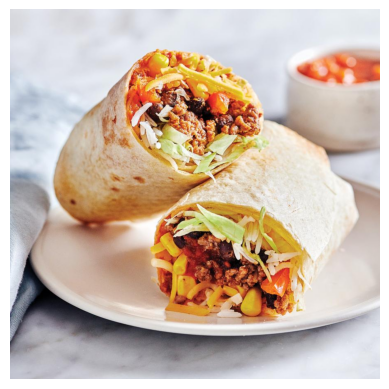

Top 1 Predicted Classes spider web, spider's web


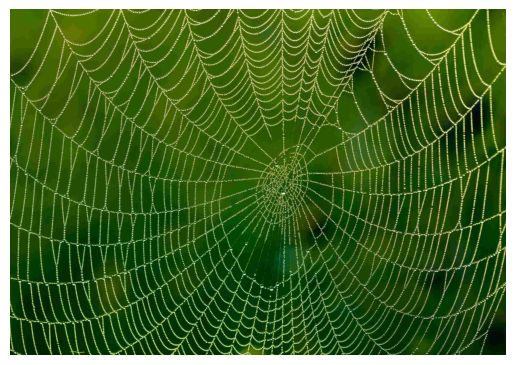

'Rank-1 Accuracy = 57.14'

In [26]:
getRankN(model, data_dir + "/class1/", ground_truth, N=1)

Top 10 Predicted Classes limousine, limo ,beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon ,convertible ,pickup, pickup truck ,ambulance ,grille, radiator grille ,police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria ,minivan ,minibus ,car wheel


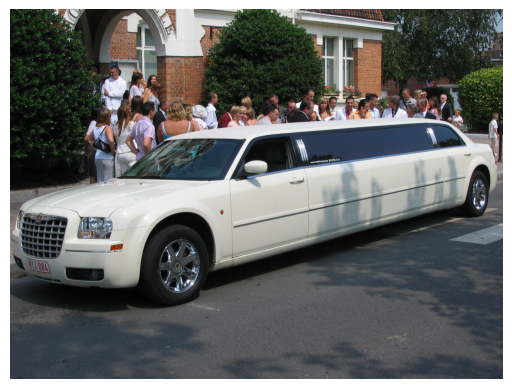

Top 10 Predicted Classes basketball ,volleyball ,ping-pong ball ,rugby ball ,soccer ball ,croquet ball ,tennis ball ,baseball ,punching bag, punch bag, punching ball, punchball ,golf ball


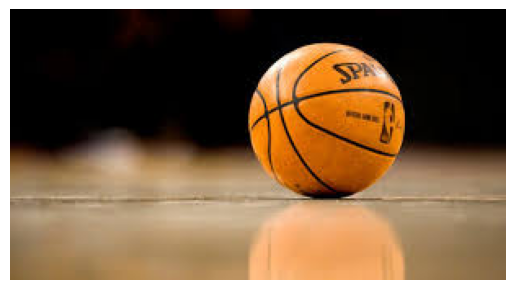

Top 10 Predicted Classes Afghan hound, Afghan ,collie ,borzoi, Russian wolfhound ,briard ,Saluki, gazelle hound ,Shetland sheepdog, Shetland sheep dog, Shetland ,Great Pyrenees ,golden retriever ,Tibetan terrier, chrysanthemum dog ,kuvasz


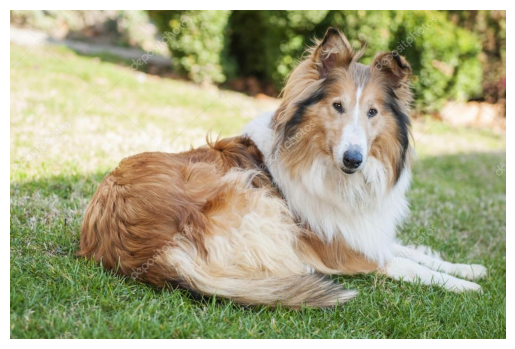

Top 10 Predicted Classes doormat, welcome mat ,chest ,paper towel ,toilet tissue, toilet paper, bathroom tissue ,carton ,tray ,washbasin, handbasin, washbowl, lavabo, wash-hand basin ,ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin ,dishrag, dishcloth ,apiary, bee house


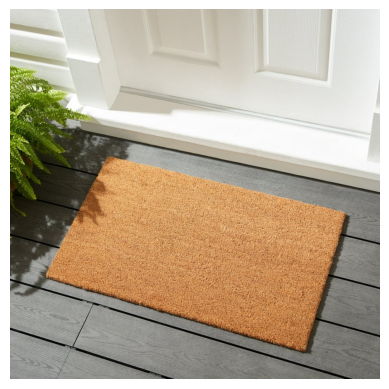

Top 10 Predicted Classes pinwheel ,Christmas stocking ,handkerchief, hankie, hanky, hankey ,umbrella ,apron ,pillow ,bonnet, poke bonnet ,sock ,bib ,pajama, pyjama, pj's, jammies


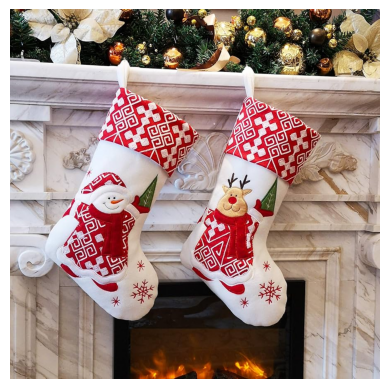

Top 10 Predicted Classes plate ,eggnog ,face powder ,bagel, beigel ,ice cream, icecream ,burrito ,hotdog, hot dog, red hot ,spaghetti squash ,French loaf ,lotion


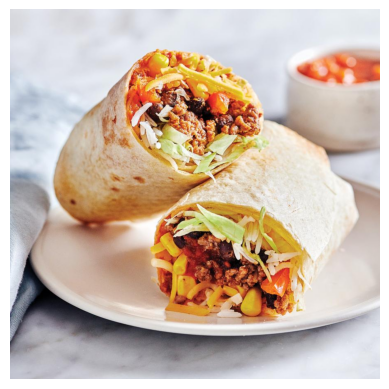

Top 10 Predicted Classes spider web, spider's web ,barn spider, Araneus cavaticus ,garden spider, Aranea diademata ,black and gold garden spider, Argiope aurantia ,wolf spider, hunting spider ,jellyfish ,maze, labyrinth ,black widow, Latrodectus mactans ,mosquito net ,shower curtain


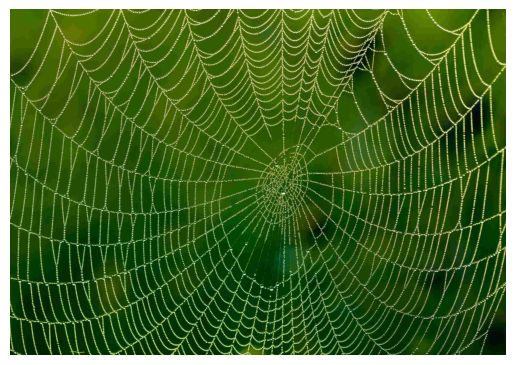

'Rank-10 Accuracy = 100.00'

In [27]:
getRankN(model, data_dir + "/class1/", ground_truth, N=10)

## Keras

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

model = MobileNetV2(weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [41]:
import cv2
from os import listdir
from os.path import isfile, join

mypath = "/content/drive/MyDrive/ColabNotebooks/Modern Computer Vision My Code/imagesDL/class1/"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
file_names

['00001.jpg',
 '00002.jpg',
 '00003.jpg',
 '00004.jpeg',
 '00005.jpg',
 '00006.jpg',
 '00007.jpg']

1/1 [==============================] - 0s 24ms/step


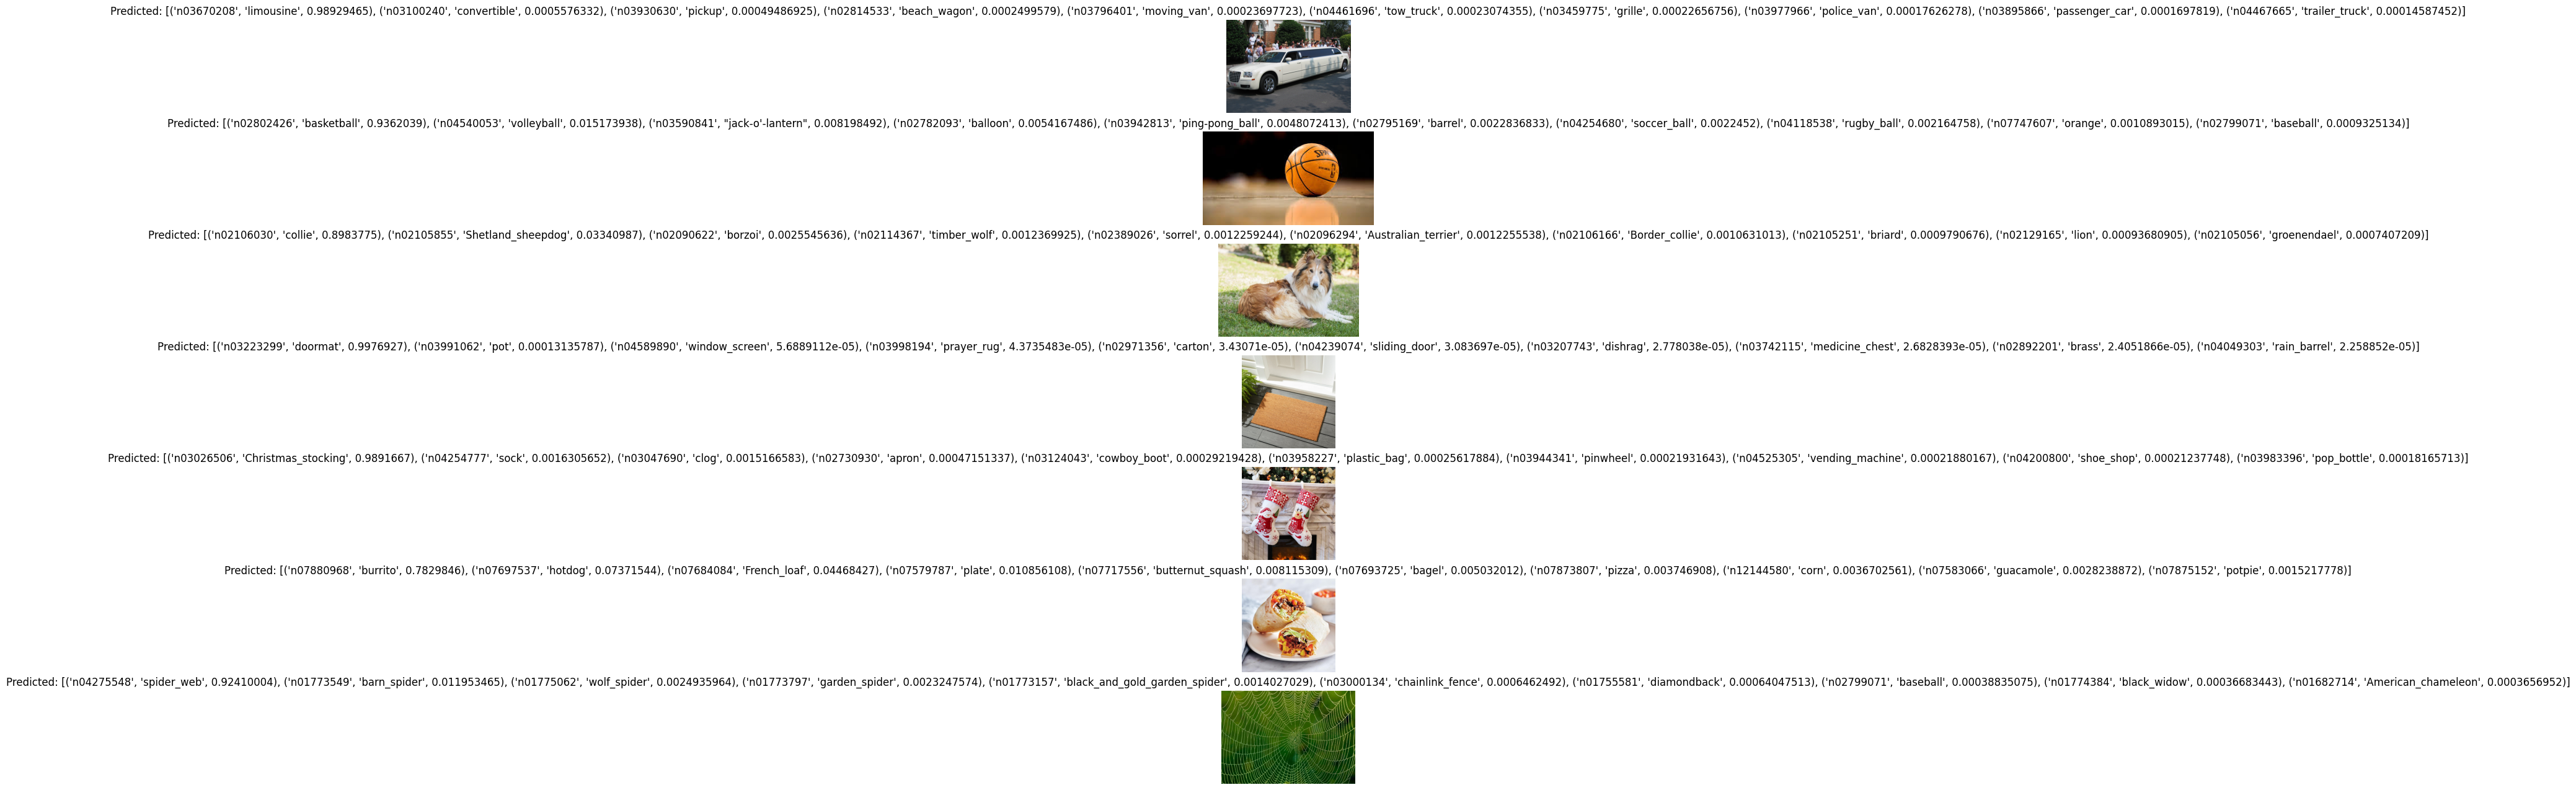

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 16))
all_top_classes = []

for (i, file) in enumerate(file_names):
  img = image.load_img(mypath+file, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  img2 = cv2.imread(mypath+file)

  preds = model.predict(x)
  predictions = decode_predictions(preds, top=10)[0]
  all_top_classes.append([x[1] for x in predictions])
  sub = fig.add_subplot(len(file_names), 1, i+1)
  sub.set_title(f"Predicted: {str(predictions)}")
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

plt.show()

In [43]:
predictions

[('n04275548', 'spider_web', 0.92410004),
 ('n01773549', 'barn_spider', 0.011953465),
 ('n01775062', 'wolf_spider', 0.0024935964),
 ('n01773797', 'garden_spider', 0.0023247574),
 ('n01773157', 'black_and_gold_garden_spider', 0.0014027029),
 ('n03000134', 'chainlink_fence', 0.0006462492),
 ('n01755581', 'diamondback', 0.00064047513),
 ('n02799071', 'baseball', 0.00038835075),
 ('n01774384', 'black_widow', 0.00036683443),
 ('n01682714', 'American_chameleon', 0.0003656952)]

In [44]:
all_top_classes

[['limousine',
  'convertible',
  'pickup',
  'beach_wagon',
  'moving_van',
  'tow_truck',
  'grille',
  'police_van',
  'passenger_car',
  'trailer_truck'],
 ['basketball',
  'volleyball',
  "jack-o'-lantern",
  'balloon',
  'ping-pong_ball',
  'barrel',
  'soccer_ball',
  'rugby_ball',
  'orange',
  'baseball'],
 ['collie',
  'Shetland_sheepdog',
  'borzoi',
  'timber_wolf',
  'sorrel',
  'Australian_terrier',
  'Border_collie',
  'briard',
  'lion',
  'groenendael'],
 ['doormat',
  'pot',
  'window_screen',
  'prayer_rug',
  'carton',
  'sliding_door',
  'dishrag',
  'medicine_chest',
  'brass',
  'rain_barrel'],
 ['Christmas_stocking',
  'sock',
  'clog',
  'apron',
  'cowboy_boot',
  'plastic_bag',
  'pinwheel',
  'vending_machine',
  'shoe_shop',
  'pop_bottle'],
 ['burrito',
  'hotdog',
  'French_loaf',
  'plate',
  'butternut_squash',
  'bagel',
  'pizza',
  'corn',
  'guacamole',
  'potpie'],
 ['spider_web',
  'barn_spider',
  'wolf_spider',
  'garden_spider',
  'black_and_go

In [74]:
ground_truth = ['limousine',
                'basketball',
                'collie',
                'doormat',
                'Christmas_stocking',
                'burrito',
                "spider_web"]

In [76]:
def getScore(all_top_classes, ground_truth, N):
  # Calcuate rank-N score
  in_labels = 0
  for (i,labels) in enumerate(all_top_classes):
    if ground_truth[i] in labels[:N]:
      in_labels += 1
  return f'Rank-{N} Accuracy = {in_labels/len(all_top_classes)*100:.2f}%'

In [77]:
getScore(all_top_classes, ground_truth, 5)

'Rank-5 Accuracy = 100.00%'

In [78]:
getScore(all_top_classes, ground_truth, 1)

'Rank-1 Accuracy = 100.00%'

In [79]:
getScore(all_top_classes, ground_truth, 10)

'Rank-10 Accuracy = 100.00%'